In [ ]:
# Colab setup
!pip install tensorflow keras matplotlib scikit-learn
from google.colab import drive
drive.mount('/content/drive')
# Update dataset path from google drive


# Jaguar Car Model Classification

## Library Imports

In [20]:
# import stuff
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import datetime
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


import sys
import platform

print("\n" + "="*60)
print("SYSTEM AND LIBRARY INFORMATION")
print("="*60)
print(f"Python Version: {sys.version}")
print(f"Platform: {platform.platform()}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")



SYSTEM AND LIBRARY INFORMATION
Python Version: 3.12.8 (main, Dec  4 2024, 08:54:12) [GCC 11.4.0]
Platform: Linux-6.8.0-1019-aws-x86_64-with-glibc2.35
TensorFlow Version: 2.20.0
Keras Version: 3.12.0
NumPy Version: 2.2.5
Pandas Version: 2.2.3
GPU Available: True


## Data Pre-processing 

### Dataset Configuration

In [ ]:
# Define dataset path and parameters
DATASET_PATH = "/content/drive/MyDrive/datasets/jaguar/"
IMG_SIZE = (224, 224)  # Standard size for ImageNet pre-trained models
IMG_SIZE_INCEPTION = (299, 299)  # InceptionV3 input size
BATCH_SIZE = 32
EPOCHS_STAGE1 = 10  # Training with frozen base (I've explained in later section)
EPOCHS_STAGE2 = 15  # Fine-tuning with unfrozen layers ("-")

# Create output directories for organized file storage
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('data', exist_ok=True)

# List all classes
classes = sorted(os.listdir(DATASET_PATH))
classes = [c for c in classes if not c.startswith('.') and os.path.isdir(os.path.join(DATASET_PATH, c))]

print(f"Found {len(classes)} car model classes:")
for i, cls in enumerate(classes, 1):
    print(f"{i}. {cls}")

Found 5 car model classes:
1. E-PACE
2. F-PACE
3. Jaguar XE
4. Jaguar XF
5. Jaguar XJ


### Create Stratified Train/Val/Test Split


- Split ratio is like this:  train (70%) / validation (15%) / test (15%) split

In [22]:
# Collect all image paths and labels
image_paths = []
labels = []

for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        img_files = [f for f in os.listdir(class_path) 
                    if not f.startswith('.') and f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        for img_file in img_files:
            image_paths.append(os.path.join(class_path, img_file))
            labels.append(class_name)

# Create DataFrame
df = pd.DataFrame({
    'filename': image_paths,
    'class': labels
})

print(f"\nTotal images: {len(df)}")
print(f"\nClass distribution:")
print(df['class'].value_counts())

# Create label encoding
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(classes))}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
df['label'] = df['class'].map(class_to_idx)

print(f"\nClass encoding: {class_to_idx}")


Total images: 2089

Class distribution:
class
E-PACE       439
Jaguar XE    425
Jaguar XJ    415
Jaguar XF    409
F-PACE       401
Name: count, dtype: int64

Class encoding: {'E-PACE': 0, 'F-PACE': 1, 'Jaguar XE': 2, 'Jaguar XF': 3, 'Jaguar XJ': 4}


In [ ]:
# Stratified split: 70% train, 15% val, 15% test
train_df, temp_df = train_test_split(
    df, 
    test_size=0.3, 
    stratify=df['label'], 
    random_state=42
)

val_df, test_df = train_test_split(
    temp_df, 
    test_size=0.5, 
    stratify=temp_df['label'], 
    random_state=42
)

print(f"\nDataset split:")
print(f"Training samples: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"Validation samples: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"Test samples: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

print(f"\nTraining set class distribution:")
print(train_df['class'].value_counts())

print(f"\nValidation set class distribution:")
print(val_df['class'].value_counts())

print(f"\nTest set class distribution:")
print(test_df['class'].value_counts())

# Save splits for reproducibility
train_df.to_csv('/content/drive/MyDrive/train_split.csv', index=False)
val_df.to_csv('/content/drive/MyDrive/val_split.csv', index=False)
test_df.to_csv('/content/drive/MyDrive/test_split.csv', index=False)
print("\n Splits saved to /content/drive/MyDrive/ directory for reproducibility")


Dataset split:
Training samples: 1462 (70.0%)
Validation samples: 313 (15.0%)
Test samples: 314 (15.0%)

Training set class distribution:
class
E-PACE       307
Jaguar XE    297
Jaguar XJ    291
Jaguar XF    286
F-PACE       281
Name: count, dtype: int64

Validation set class distribution:
class
E-PACE       66
Jaguar XE    64
Jaguar XJ    62
Jaguar XF    61
F-PACE       60
Name: count, dtype: int64

Test set class distribution:
class
E-PACE       66
Jaguar XE    64
Jaguar XF    62
Jaguar XJ    62
F-PACE       60
Name: count, dtype: int64

✓ Splits saved to data/ directory for reproducibility


### Calculate Class Weights


Need this cause data size is not consistent among all classes 

In [ ]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)

class_weight_dict = dict(enumerate(class_weights))

print("Class weights:")
for idx, weight in class_weight_dict.items():
    print(f"  {idx_to_class[idx]}: {weight:.3f}")

## Basically, higher weights for underrepresented classes help the model focus on them during training. Not needed at this point but doesnt harm either

Class weights:
  E-PACE: 0.952
  F-PACE: 1.041
  Jaguar XE: 0.985
  Jaguar XF: 1.022
  Jaguar XJ: 1.005


## Exploratory Data Analysis (EDA)

### Class Distribution Visualization

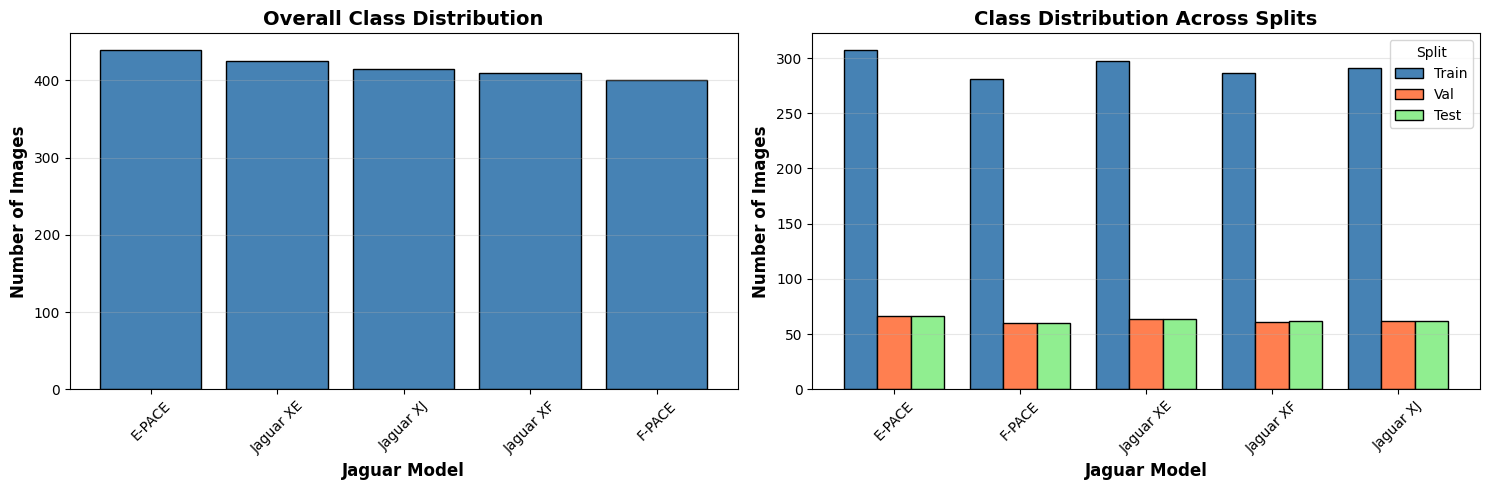

In [25]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall distribution
class_counts = df['class'].value_counts()
axes[0].bar(class_counts.index, class_counts.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Jaguar Model', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[0].set_title('Overall Class Distribution', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Distribution across splits
split_data = pd.DataFrame({
    'Train': train_df['class'].value_counts(),
    'Val': val_df['class'].value_counts(),
    'Test': test_df['class'].value_counts()
})

split_data.plot(kind='bar', ax=axes[1], color=['steelblue', 'coral', 'lightgreen'], 
                edgecolor='black', width=0.8)
axes[1].set_xlabel('Jaguar Model', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Images', fontsize=12, fontweight='bold')
axes[1].set_title('Class Distribution Across Splits', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Split')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('plots/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Sample Images Visualization

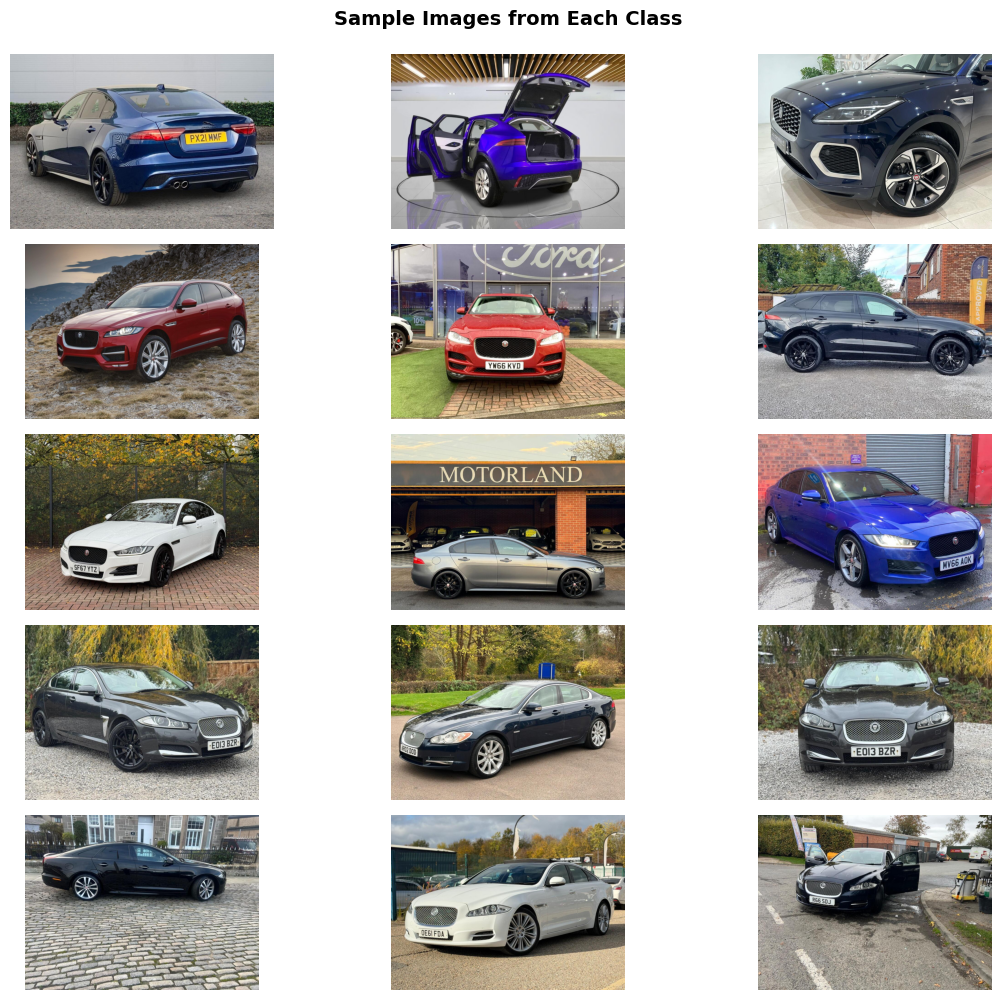

In [26]:
def display_sample_images(df, classes, samples_per_class=3):
  
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(12, 10))
    
    for i, class_name in enumerate(classes):
        class_images = df[df['class'] == class_name]['filename'].values
        sample_images = np.random.choice(class_images, min(samples_per_class, len(class_images)), replace=False)
        
        for j, img_path in enumerate(sample_images):
            img = Image.open(img_path)
            
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            
            if j == 0:
                axes[i, j].set_ylabel(class_name, fontsize=10, fontweight='bold', 
                                     rotation=0, ha='right', va='center')
    
    plt.suptitle('Sample Images from Each Class', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('plots/sample_images.png', dpi=300, bbox_inches='tight')
    plt.show()

display_sample_images(train_df, classes)

### Create Data Generators



In [27]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

# No augmentation for validation/test
val_test_datagen = ImageDataGenerator(preprocessing_function=mobilenet_preprocess)

# Create generators from dataframes
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"\nTraining samples: {train_generator.n}")
print(f"Validation samples: {val_generator.n}")
print(f"Test samples: {test_generator.n}")
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Class indices: {train_generator.class_indices}")

Found 1462 validated image filenames belonging to 5 classes.
Found 313 validated image filenames belonging to 5 classes.
Found 314 validated image filenames belonging to 5 classes.

Training samples: 1462
Validation samples: 313
Test samples: 314
Number of classes: 5
Class indices: {'E-PACE': 0, 'F-PACE': 1, 'Jaguar XE': 2, 'Jaguar XF': 3, 'Jaguar XJ': 4}


## Model Implementation 

### MobileNetV2 


In [28]:
def create_mobilenet_model(num_classes, img_size=(224, 224), trainable=False):
    # Load pre-trained MobileNetV2 (headless)
    base_model = MobileNetV2(
        input_shape=(*img_size, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Set trainable parameter
    base_model.trainable = trainable
    
    # Simplified classification head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.55),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create MobileNetV2 model (initially with frozen base)
mobilenet_model = create_mobilenet_model(num_classes=len(train_generator.class_indices), trainable=False)

# Compile model
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("MobileNetV2 Model Architecture (Simplified):")
mobilenet_model.summary()
print(f"\nTotal trainable parameters: {mobilenet_model.count_params():,}")

MobileNetV2 Model Architecture (Simplified):


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)


Total trainable parameters: 2,264,389


#### Training MobileNetV2


In [ ]:
print("\n" + "="*70)
print("MOBILENETV2 TRAINING - 2-STAGE APPROACH")
print("="*70)

# Stage 1: Train with frozen base
## Here we build on top of pretrained model, not actually training the model layers
print("\n--- Stage 1: Training top layers (frozen base) ---")

callbacks_stage1 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
]

start_time = datetime.datetime.now()

history_stage1 = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks_stage1,
    class_weight=class_weight_dict, 
    verbose=1
)

# Stage 2: Fine-tune with unfrozen base model
## Here we are actually finetuning the final few layers of the pretrained models
print("\n--- Stage 2: Fine-tuning (unfrozen base) ---")

# Unfreeze the base model
mobilenet_model.layers[0].trainable = True

# Freeze early layers (first 100 of 154 layers)
for layer in mobilenet_model.layers[0].layers[:100]:
    layer.trainable = False

print(f"Total layers: {len(mobilenet_model.layers[0].layers)}")
print(f"Trainable layers: {sum([1 for layer in mobilenet_model.layers[0].layers if layer.trainable])}")

# Recompile with lower learning rate
mobilenet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_stage2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/models/mobilenetv2_best.keras', monitor='val_accuracy',
                   save_best_only=True, verbose=1, mode='max')
]

history_stage2 = mobilenet_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks_stage2,
    class_weight=class_weight_dict,  
    verbose=1
)

end_time = datetime.datetime.now()
training_time_mobilenet = (end_time - start_time).total_seconds()

print(f"\nMobileNetV2 Total Training Time: {training_time_mobilenet:.2f} seconds")
print(f"Training Time: {training_time_mobilenet/60:.2f} minutes")

# Combine histories for plotting
history_mobilenet = type('History', (), {})()
history_mobilenet.history = {
    'accuracy': history_stage1.history['accuracy'] + history_stage2.history['accuracy'],
    'val_accuracy': history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy'],
    'loss': history_stage1.history['loss'] + history_stage2.history['loss'],
    'val_loss': history_stage1.history['val_loss'] + history_stage2.history['val_loss']
}


MOBILENETV2 TRAINING - 2-STAGE APPROACH

--- Stage 1: Training top layers (frozen base) ---
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 49s 912ms/step - accuracy: 0.2052 - loss: 2.0682 - val_accuracy: 0.3227 - val_loss: 1.5495 - learning_rate: 0.0010
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 733ms/step - accuracy: 0.2962 - loss: 1.7595 - val_accuracy: 0.4281 - val_loss: 1.4003 - learning_rate: 0.0010
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 729ms/step - accuracy: 0.3680 - loss: 1.6224 - val_accuracy: 0.4441 - val_loss: 1.3247 - learning_rate: 0.0010
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 733ms/step - accuracy: 0.3618 - loss: 1.5420 - val_accuracy: 0.4888 - val_loss: 1.2440 - learning_rate: 0.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 733ms/step - accuracy: 0.3974 - loss: 1.4937 - val_accuracy: 0.5304 - val_loss: 1.1982 - learning_rate: 0.0010
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 34s 740ms/step - accuracy: 0.4453 - loss: 1.4137 - val_accuracy: 0.5208 - val_loss: 1.1818 - learning_ra

### InceptionV3 Implementation



In [ ]:
# InceptionV3 data generators (299x299 input size)
train_datagen_inception = ImageDataGenerator(
    preprocessing_function=inception_preprocess,
    rotation_range=30,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_test_datagen_inception = ImageDataGenerator(preprocessing_function=inception_preprocess)

# Use same dataframe splits
train_generator_inception = train_datagen_inception.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE_INCEPTION,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

val_generator_inception = val_test_datagen_inception.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE_INCEPTION,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator_inception = val_test_datagen_inception.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE_INCEPTION,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

def create_inception_model(num_classes, img_size=(299, 299), trainable=False):
    # Load pre-trained InceptionV3 (headless)
    base_model = InceptionV3(
        input_shape=(*img_size, 3),
        include_top=False,
        weights='imagenet'
    )
    
    # Set trainable parameter
    base_model.trainable = trainable
    
    # Simplified classification head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.55),
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Create InceptionV3 model
inception_model = create_inception_model(num_classes=len(train_generator_inception.class_indices), trainable=False)

# Compile model
inception_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("InceptionV3 Model Architecture (Simplified):")
inception_model.summary()
print(f"\nTotal trainable parameters: {inception_model.count_params():,}")

Found 755 validated image filenames belonging to 5 classes.
Found 162 validated image filenames belonging to 5 classes.
Found 162 validated image filenames belonging to 5 classes.
InceptionV3 Model Architecture (Simplified):


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │        10,245 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,813,029 (83.21 MB)

 Trainable params: 10,245 (40.02 KB)

 Non-trainable params: 21,802,784 (83.17 MB)


Total trainable parameters: 21,813,029


#### Training InceptionV3

In [ ]:
print("\n" + "="*70)
print("INCEPTIONV3 TRAINING - 2-STAGE APPROACH ")
print("="*70)

# Stage 1: Train with frozen base
print("\n--- Stage 1: Training top layers (frozen base) ---")

callbacks_inception_stage1 = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-7, verbose=1)
]

start_time = datetime.datetime.now()

history_inception_stage1 = inception_model.fit(
    train_generator_inception,
    validation_data=val_generator_inception,
    epochs=EPOCHS_STAGE1,
    callbacks=callbacks_inception_stage1,
    class_weight=class_weight_dict,
    verbose=1
)

# Stage 2: Fine-tune
print("\n--- Stage 2: Fine-tuning (unfrozen base) ---")

# Unfreeze the base model
inception_model.layers[0].trainable = True

# Freeze early layers (first 200 of 311 layers)
for layer in inception_model.layers[0].layers[:200]:
    layer.trainable = False

print(f"Total layers: {len(inception_model.layers[0].layers)}")
print(f"Trainable layers: {sum([1 for layer in inception_model.layers[0].layers if layer.trainable])}")

# Recompile with lower learning rate
inception_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks_inception_stage2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/models/inceptionv3_best.keras', monitor='val_accuracy',
                   save_best_only=True, verbose=1, mode='max')
]

history_inception_stage2 = inception_model.fit(
    train_generator_inception,
    validation_data=val_generator_inception,
    epochs=EPOCHS_STAGE2,
    callbacks=callbacks_inception_stage2,
    class_weight=class_weight_dict,
    verbose=1
)

end_time = datetime.datetime.now()
training_time_inception = (end_time - start_time).total_seconds()

print(f"\nInceptionV3 Total Training Time: {training_time_inception:.2f} seconds")
print(f"Training Time: {training_time_inception/60:.2f} minutes")

# Combine histories
history_inception = type('History', (), {})()
history_inception.history = {
    'accuracy': history_inception_stage1.history['accuracy'] + history_inception_stage2.history['accuracy'],
    'val_accuracy': history_inception_stage1.history['val_accuracy'] + history_inception_stage2.history['val_accuracy'],
    'loss': history_inception_stage1.history['loss'] + history_inception_stage2.history['loss'],
    'val_loss': history_inception_stage1.history['val_loss'] + history_inception_stage2.history['val_loss']
}

## Results & Comparison 
### Training History Visualization

In [ ]:
def plot_training_history(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    epochs = range(1, len(history.history['accuracy']) + 1)
    
    # Accuracy plot
    axes[0].plot(epochs, history.history['accuracy'], label='Training Accuracy', linewidth=2, marker='o')
    axes[0].plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='s')
    axes[0].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    axes[0].set_title(f'{model_name} - Training and Validation Accuracy', fontsize=13, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Add horizontal line for final val accuracy
    final_val_acc = history.history['val_accuracy'][-1]
    axes[0].axhline(y=final_val_acc, color='r', linestyle='--', alpha=0.5, 
                   label=f'Final Val Acc: {final_val_acc:.3f}')
    axes[0].legend()
    
    # Loss plot
    axes[1].plot(epochs, history.history['loss'], label='Training Loss', linewidth=2, marker='o')
    axes[1].plot(epochs, history.history['val_loss'], label='Validation Loss', linewidth=2, marker='s')
    axes[1].set_xlabel('Epoch', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Loss', fontsize=12, fontweight='bold')
    axes[1].set_title(f'{model_name} - Training and Validation Loss', fontsize=13, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'plots/{model_name.lower()}_training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot training histories
plot_training_history(history_mobilenet, 'MobileNetV2')
plot_training_history(history_inception, 'InceptionV3')

### Model Evaluation on Test Set


In [ ]:
# Evaluate MobileNetV2
print("="*70)
print("MOBILENETV2 EVALUATION")
print("="*70)

# Validation set
val_loss_mobilenet, val_acc_mobilenet = mobilenet_model.evaluate(val_generator, verbose=0)
print(f"\nValidation Loss: {val_loss_mobilenet:.4f}")
print(f"Validation Accuracy: {val_acc_mobilenet:.4f} ({val_acc_mobilenet*100:.2f}%)")

# Test set
test_loss_mobilenet, test_acc_mobilenet = mobilenet_model.evaluate(test_generator, verbose=0)
print(f"\nTest Loss: {test_loss_mobilenet:.4f}")
print(f"Test Accuracy: {test_acc_mobilenet:.4f} ({test_acc_mobilenet*100:.2f}%)")

# Predictions on test set
test_generator.reset()
y_pred_mobilenet = mobilenet_model.predict(test_generator, verbose=0)
y_pred_classes_mobilenet = np.argmax(y_pred_mobilenet, axis=1)
y_true_mobilenet = test_generator.classes

# Classification report
print("\nTest Set Classification Report:")
print("="*70)
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true_mobilenet, y_pred_classes_mobilenet, 
                           target_names=class_names, digits=4))

# Calculate metrics
precision_mobilenet = precision_score(y_true_mobilenet, y_pred_classes_mobilenet, average='weighted')
recall_mobilenet = recall_score(y_true_mobilenet, y_pred_classes_mobilenet, average='weighted')
f1_mobilenet = f1_score(y_true_mobilenet, y_pred_classes_mobilenet, average='weighted')

print(f"\nWeighted Metrics:")
print(f"  Precision: {precision_mobilenet:.4f}")
print(f"  Recall: {recall_mobilenet:.4f}")
print(f"  F1-Score: {f1_mobilenet:.4f}")

MOBILENETV2 EVALUATION

Validation Loss: 0.4510
Validation Accuracy: 0.8395 (83.95%)

Test Loss: 0.5541
Test Accuracy: 0.7840 (78.40%)

Test Set Classification Report:
              precision    recall  f1-score   support

      E-PACE     0.8537    0.8750    0.8642        40
      F-PACE     0.8421    0.7805    0.8101        41
   Jaguar XE     0.6500    0.6190    0.6341        21
   Jaguar XF     0.5000    0.5882    0.5405        17
   Jaguar XJ     0.8605    0.8605    0.8605        43

    accuracy                         0.7840       162
   macro avg     0.7412    0.7446    0.7419       162
weighted avg     0.7890    0.7840    0.7857       162


Weighted Metrics:
  Precision: 0.7890
  Recall: 0.7840
  F1-Score: 0.7857


In [ ]:
# Evaluate InceptionV3
print("\n" + "="*70)
print("INCEPTIONV3 EVALUATION")
print("="*70)

# Validation set
val_loss_inception, val_acc_inception = inception_model.evaluate(val_generator_inception, verbose=0)
print(f"\nValidation Loss: {val_loss_inception:.4f}")
print(f"Validation Accuracy: {val_acc_inception:.4f} ({val_acc_inception*100:.2f}%)")

# Test set
test_loss_inception, test_acc_inception = inception_model.evaluate(test_generator_inception, verbose=0)
print(f"\nTest Loss: {test_loss_inception:.4f}")
print(f"Test Accuracy: {test_acc_inception:.4f} ({test_acc_inception*100:.2f}%)")

# Predictions on test set
test_generator_inception.reset()
y_pred_inception = inception_model.predict(test_generator_inception, verbose=0)
y_pred_classes_inception = np.argmax(y_pred_inception, axis=1)
y_true_inception = test_generator_inception.classes

# Classification report
print("\nTest Set Classification Report:")
print("="*70)
print(classification_report(y_true_inception, y_pred_classes_inception, 
                           target_names=class_names, digits=4))

# Calculate metrics
precision_inception = precision_score(y_true_inception, y_pred_classes_inception, average='weighted')
recall_inception = recall_score(y_true_inception, y_pred_classes_inception, average='weighted')
f1_inception = f1_score(y_true_inception, y_pred_classes_inception, average='weighted')

print(f"\nWeighted Metrics:")
print(f"  Precision: {precision_inception:.4f}")
print(f"  Recall: {recall_inception:.4f}")
print(f"  F1-Score: {f1_inception:.4f}")


INCEPTIONV3 EVALUATION

Validation Loss: 0.3754
Validation Accuracy: 0.8642 (86.42%)

Test Loss: 0.3150
Test Accuracy: 0.8765 (87.65%)

Test Set Classification Report:
              precision    recall  f1-score   support

      E-PACE     0.9024    0.9250    0.9136        40
      F-PACE     0.8372    0.8780    0.8571        41
   Jaguar XE     0.8333    0.7143    0.7692        21
   Jaguar XF     0.8667    0.7647    0.8125        17
   Jaguar XJ     0.9111    0.9535    0.9318        43

    accuracy                         0.8765       162
   macro avg     0.8702    0.8471    0.8569       162
weighted avg     0.8755    0.8765    0.8748       162


Weighted Metrics:
  Precision: 0.8755
  Recall: 0.8765
  F1-Score: 0.8748


### Confusion Matrices

In [ ]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name):
    cm = confusion_matrix(y_true, y_pred)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    plt.figure(figsize=(10, 8))
    
    # Create annotations with both count and percentage
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'
    
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.xlabel('Predicted', fontsize=12, fontweight='bold')
    plt.ylabel('True', fontsize=12, fontweight='bold')
    plt.title(f'{model_name} - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'plots/{model_name.lower()}_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_true_mobilenet, y_pred_classes_mobilenet, class_names, 'MobileNetV2')
plot_confusion_matrix(y_true_inception, y_pred_classes_inception, class_names, 'InceptionV3')

### Model Comparison

In [ ]:
# Create comparison table
comparison_data = {
    'Model': ['MobileNetV2', 'InceptionV3'],
    'Val Accuracy': [f"{val_acc_mobilenet:.4f}", f"{val_acc_inception:.4f}"],
    'Test Accuracy': [f"{test_acc_mobilenet:.4f}", f"{test_acc_inception:.4f}"],
    'Precision': [f"{precision_mobilenet:.4f}", f"{precision_inception:.4f}"],
    'Recall': [f"{recall_mobilenet:.4f}", f"{recall_inception:.4f}"],
    'F1-Score': [f"{f1_mobilenet:.4f}", f"{f1_inception:.4f}"],
    'Training Time (sec)': [f"{training_time_mobilenet:.2f}", f"{training_time_inception:.2f}"]
}

df_comparison = pd.DataFrame(comparison_data)

print("\n" + "="*90)
print("MODEL PERFORMANCE COMPARISON (IMPROVED)")
print("="*90)
print(df_comparison.to_string(index=False))
print("="*90)

# Visualize comparison
fig, ax = plt.subplots(figsize=(12, 6))

metrics = ['Val Accuracy', 'Test Accuracy', 'Precision', 'Recall', 'F1-Score']
mobilenet_values = [val_acc_mobilenet, test_acc_mobilenet, precision_mobilenet, 
                   recall_mobilenet, f1_mobilenet]
inception_values = [val_acc_inception, test_acc_inception, precision_inception, 
                   recall_inception, f1_inception]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, mobilenet_values, width, label='MobileNetV2', 
              color='steelblue', edgecolor='black')
bars2 = ax.bar(x + width/2, inception_values, width, label='InceptionV3', 
              color='coral', edgecolor='black')

ax.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison (Test Set)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=15)
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim([0, 1.0])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('plots/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save comparison to CSV
df_comparison.to_csv('/content/drive/MyDrive/model_comparison.csv', index=False)

### Sample Predictions

In [ ]:
def display_predictions(model, df, class_names, model_name, preprocessing_func, img_size, num_samples=9):
    # Sample random images from test set
    sample_df = df.sample(n=min(num_samples, len(df)), random_state=42)
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.ravel()
    
    for i, (idx, row) in enumerate(sample_df.iterrows()):
        # Load and preprocess image
        img = load_img(row['filename'], target_size=img_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocessing_func(img_array)
        
        # Predict
        prediction = model.predict(img_array, verbose=0)
        pred_class_idx = np.argmax(prediction)
        pred_class = class_names[pred_class_idx]
        confidence = prediction[0][pred_class_idx] * 100
        
        # Display
        axes[i].imshow(img)
        axes[i].axis('off')
        
        true_label = row['class']
        color = 'green' if true_label == pred_class else 'red'
        axes[i].set_title(f'True: {true_label}\nPred: {pred_class} ({confidence:.1f}%)',
                         fontsize=9, color=color, fontweight='bold')
    
    plt.suptitle(f'{model_name} - Sample Predictions (Test Set)', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(f'plots/{model_name.lower()}_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Display predictions
display_predictions(mobilenet_model, test_df, class_names, 'MobileNetV2', mobilenet_preprocess, IMG_SIZE)
display_predictions(inception_model, test_df, class_names, 'InceptionV3', inception_preprocess, IMG_SIZE_INCEPTION)

## Save Models

In [ ]:
# Save final models
mobilenet_model.save('/content/drive/MyDrive/models/mobilenetv2_jaguar_final.keras')
inception_model.save('/content/drive/MyDrive/models/inceptionv3_jaguar_final.keras')

print("="*70)
print("MODELS SAVED SUCCESSFULLY")
print("="*70)
print("\nFinal models:")
print("/content/drive/MyDrive/models/mobilenetv2_jaguar_final.keras")
print("/content/drive/MyDrive/models/inceptionv3_jaguar_final.keras")
print("\nBest models from training (highest val_accuracy):")
print("/content/drive/MyDrive/models/mobilenetv2_best.keras")
print("/content/drive/MyDrive/models/inceptionv3_best.keras")
print("="*70)